# Test parameter shift using qiskit circuit

In [16]:
import numpy as np
from qiskit import *
from qiskit.tools.monitor import job_monitor
#import qiskit.tools.jupyter
from qiskit.tools.visualization import circuit_drawer, plot_histogram
import copy

## Target

Minimize the energy of two qubit going through one X gate using parameter shift rule


In [2]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)
qc.rxx(np.pi/2,1,0)
qc.ryy(np.pi/2,1,0)
qc.measure(q,c)
qc.draw()


┌───────────┐┌───────────┐┌─┐   
q0_0: ┤1          ├┤1          ├┤M├───
      │  Rxx(π/2) ││  Ryy(π/2) │└╥┘┌─┐
q0_1: ┤0          ├┤0          ├─╫─┤M├
      └───────────┘└───────────┘ ║ └╥┘
c0: 2/═══════════════════════════╩══╩═
                                 0  1

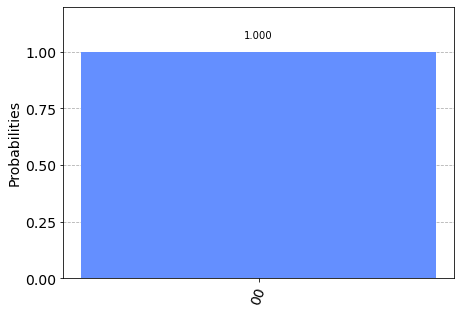

In [3]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=100)
plot_histogram(job.result().get_counts(qc))

## Create a variational ensemble
using $Z$ gate

In [4]:
N = 4
q = QuantumRegister(N)
c = ClassicalRegister(N)
qc = QuantumCircuit(q,c)

thetas = np.random.rand(3 * N)
for i in range(N):
    qc.rx(thetas[i] * np.pi/2,i)
    qc.ry(thetas[i] * np.pi/2,i)
    qc.rz(thetas[i] * np.pi/2,i)

qc.measure(q,c)
qc.draw()


┌────────────┐ ┌────────────┐ ┌────────────┐┌─┐         
q12_0: ─┤ Rx(1.1023) ├─┤ Ry(1.1023) ├─┤ Rz(1.1023) ├┤M├─────────
       ┌┴────────────┤┌┴────────────┤┌┴────────────┤└╥┘┌─┐      
q12_1: ┤ Rx(0.25371) ├┤ Ry(0.25371) ├┤ Rz(0.25371) ├─╫─┤M├──────
       └┬────────────┤└┬────────────┤└┬────────────┤ ║ └╥┘┌─┐   
q12_2: ─┤ Rx(1.3764) ├─┤ Ry(1.3764) ├─┤ Rz(1.3764) ├─╫──╫─┤M├───
       ┌┴────────────┤┌┴────────────┤┌┴────────────┤ ║  ║ └╥┘┌─┐
q12_3: ┤ Rx(0.20452) ├┤ Ry(0.20452) ├┤ Rz(0.20452) ├─╫──╫──╫─┤M├
       └─────────────┘└─────────────┘└─────────────┘ ║  ║  ║ └╥┘
 c1: 4/══════════════════════════════════════════════╩══╩══╩══╩═
                                                     0  1  2  3

/Users/qwe/miniforge3/envs/qi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/qwe/miniforge3/envs/qi/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


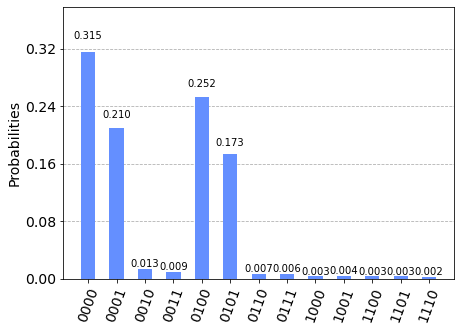

In [5]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
plot_histogram(job.result().get_counts(qc))

In [6]:
sigma_z = np.array([[1,0],[0,-1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,1],[1,0]])

spin = np.array([0,1])
spin_up = np.array([[1],[0]])
spin_down= np.array([[0],[1]])

In [7]:
def state_to_vec(s):
    # return a probability with the corresponding state
    if s[0] == '1':
        state = spin_up
        state_mat = spin_up
    else:
        state = spin_down
        state_mat = spin_down
    
    for curr in s[1:]:
        if curr == '1':
            state = np.kron(state,spin_up)
            state_mat = np.hstack((state_mat,spin_up))
        else:
            state = np.kron(state,spin_down)
            state_mat = np.hstack((state_mat,spin_down))
    
    return state,state_mat

In [8]:
res = job.result().get_counts(qc)

In [9]:
res.get('0000',0)

315

In [17]:
class QuGateWithGrad:
    rDict = {'Rx': 0.5, 'Ry':0.5, 'Rz':0.5, 'Rxx': np.pi/2, 'Ryy': np.pi/2,'Rzz': np.pi/2}

    qiskitGateDict = {'Rx':QuantumCircuit.rx, 'Ry':QuantumCircuit.ry,'Rz':QuantumCircuit.rz,
    'Rxx':QuantumCircuit.rxx,'Ryy':QuantumCircuit.ryy,'Rzz':QuantumCircuit.rzz}

    def __init__(self,symbol: str, theta: float, registerNum: tuple):
        self.qiskitGate = self.qiskitGateDict[symbol]
        self.r = self.rDict[symbol]
        
        self.registerNum = registerNum
        self.symbol = symbol
        self.gradNum = 0 # gradNum -1/+1 add or minus r
    
    
    def put(self,theta) -> tuple:
        
        return self.qiskitGate, theta + self.gradNum*self.r, self.r
    

    def setGrad(self,gradNum):

        assert gradNum == -1 or gradNum == 1

        self.gradNum = gradNum
    
    

In [18]:
class QuCircWithGrad:


    def __init__(self,N : int):
        self.thetas = []
        self.gates = []
        self.regiNums = []
        self.isConstructed = False
        self.qc = None
    
    def add_gate(self,symbol: str,registerNum: tuple,newTheta = None):
        '''
        add a gate with a random theta
        '''
        if type(registerNum) is int:
            registerNum = tuple([registerNum])
        
        if not newTheta:
            newTheta = np.random.random() * 2 * np.pi
        
        newGate = QuGateWithGrad(symbol,newTheta,registerNum)
        self.regiNums.append(registerNum)
        self.gates.append(newGate)
        self.thetas.append(newTheta)

    def genGradCirc(self,gradIdx : int):
        """
        generate two circuit with plus and minus gradient
        """
        newCircPlus = copy.deepcopy(self)
        newCircMinus = copy.deepcopy(self)

        newCircPlus.gates[gradIdx].setGrad(1)
        newCircMinus.gates[gradIdx].setGrad(-1)

        newCircPlus.construct()
        newCircMinus.construct()

        return newCircPlus,newCircMinus


    def construct(self):
        '''
        construct the circuit using added gates and append measure
        '''
        self.q = QuantumRegister(N)
        self.c = ClassicalRegister(N)
        self.qc = QuantumCircuit(self.q,self.c)

        for i in range(len(self.gates)):
            gate = self.gates[i]
            theta = self.thetas[i]
            registerNum = self.regiNums[i]
            kitGate, para, _ = gate.put(theta)
            kitGate(self.qc,para,*registerNum)
        
        self.qc.measure(self.q,self.c)
    
    def draw(self):
        self.qc.draw()
    

        

In [19]:
N = 4
test1 = QuCircWithGrad(N)

for i in range(N):
    test1.add_gate('Rx',i)
    test1.add_gate('Ry',i)
    test1.add_gate('Rz',i)

test1.add_gate('Rxx',(0,1))
test1.construct()
k = test1.qc
k.draw()

┌────────────┐┌────────────┐ ┌────────────┐┌──────────────┐   ┌─┐   
q7_0: ─┤ Rx(2.1187) ├┤ Ry(3.9397) ├─┤ Rz(1.2589) ├┤0             ├───┤M├───
      ┌┴────────────┤├────────────┤ ├────────────┤│  Rxx(4.9659) │   └╥┘┌─┐
q7_1: ┤ Rx(0.93736) ├┤ Ry(3.6019) ├─┤ Rz(5.8618) ├┤1             ├────╫─┤M├
      ├─────────────┤├────────────┤┌┴────────────┤└─────┬─┬──────┘    ║ └╥┘
q7_2: ┤ Rx(0.64212) ├┤ Ry(5.0952) ├┤ Rz(0.81171) ├──────┤M├───────────╫──╫─
      └┬────────────┤├────────────┤└┬────────────┤      └╥┘       ┌─┐ ║  ║ 
q7_3: ─┤ Rx(1.0703) ├┤ Ry(5.2902) ├─┤ Rz(5.7932) ├───────╫────────┤M├─╫──╫─
       └────────────┘└────────────┘ └────────────┘       ║        └╥┘ ║  ║ 
c7: 4/═══════════════════════════════════════════════════╩═════════╩══╩══╩═
                                                         2         3  0  1

In [94]:
N = 4
q = QuantumRegister(N)
c = ClassicalRegister(N)
qc = QuantumCircuit(q,c)

thetas = np.random.rand(3 * N)
for i in range(N):
    qc.rx(thetas[i] * np.pi/2,i)
    qc.ry(thetas[i] * np.pi/2,i)
    qc.rz(thetas[i] * np.pi/2,i)

qc.measure(q,c)
qc.draw()

┌─────────────┐┌─────────────┐┌─────────────┐┌─┐         
q60_0: ┤ Rx(0.43649) ├┤ Ry(0.43649) ├┤ Rz(0.43649) ├┤M├─────────
       └┬───────────┬┘└┬───────────┬┘└┬───────────┬┘└╥┘┌─┐      
q60_1: ─┤ Rx(2/15π) ├──┤ Ry(2/15π) ├──┤ Rz(2/15π) ├──╫─┤M├──────
        ├───────────┴┐ ├───────────┴┐ ├───────────┴┐ ║ └╥┘┌─┐   
q60_2: ─┤ Rx(0.1006) ├─┤ Ry(0.1006) ├─┤ Rz(0.1006) ├─╫──╫─┤M├───
       ┌┴────────────┤┌┴────────────┤┌┴────────────┤ ║  ║ └╥┘┌─┐
q60_3: ┤ Rx(0.76906) ├┤ Ry(0.76906) ├┤ Rz(0.76906) ├─╫──╫──╫─┤M├
       └─────────────┘└─────────────┘└─────────────┘ ║  ║  ║ └╥┘
c37: 4/══════════════════════════════════════════════╩══╩══╩══╩═
                                                     0  1  2  3